# All Regression Notebook
## Load data
Declare and load the library, then load the dataset. Since the data do not contain the naming of columns, we had to add it in using a manual Python list

We will have `all_train_data` and `all_test_data`, which had been concatenated into their respective `DataFrame`.

# Reprocessing Data

## Import Library

In [13]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Define Column Titles


In [14]:
columns_name = ["Popularity", "Check-in", "Activities", "Category"] \
            + ["F_{:d}".format(i) for i in range(1, 26)] \
            + ["CC{:d}".format(i) for i in range(1, 6)] \
            + ["Base time", "Post length", "Post count", "Post promotion", "Span time"] \
            + ["Post_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Base_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Span count"]

In [15]:
len(columns_name)

54

## Extract Data

### Extract All Train Datasets

In [16]:
all_train_data = [pandas.read_csv("/content/drive/MyDrive/FUNIX Progress/MLP302x_1.1-A_EN/Assignment 2/Dataset/Training/Features_Variant_{:d}.csv".format(d), header=None) for d in range(1, 6)]

### Extract All Test Datasets

In [17]:
all_test_data = [pandas.read_csv("/content/drive/MyDrive/FUNIX Progress/MLP302x_1.1-A_EN/Assignment 2/Dataset/Testing/TestSet/Test_Case_{:d}.csv".format(d), header=None) for d in range(1, 10)]

## Build Dataframe

### Training Dataframe

In [18]:
full_train_data = pandas.DataFrame(all_train_data[0])

for i in range(1, 5):
  full_train_data.append(all_train_data[i])

full_train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,65,166,2,0,24,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,10,132,1,0,24,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,14,133,2,0,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,7,0,3,7,-3,62,131,1,0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,1,0,0,1,0,58,142,5,0,24,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [19]:
train_data = full_train_data
train_data.columns = columns_name
train_data["bias"] = 1

train_data.head()

,Popularity,Check-in,Activities,Category,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,CC1,CC2,CC3,CC4,CC5,Base time,Post length,Post count,Post promotion,Span time,Post_date_1,Post_date_2,Post_date_3,Post_date_4,Post_date_5,Post_date_6,Post_date_7,Base_date_1,Base_date_2,Base_date_3,Base_date_4,Base_date_5,Base_date_6,Base_date_7,Span count,bias
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,65,166,2,0,24,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,10,132,1,0,24,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,0,0,0,0,0,14,133,2,0,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,7,0,3,7,-3,62,131,1,0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,806.0,7.574627,0.0,69.435826,0.0,76.0,2.604478,0.0,8.505502,0.0,806.0,10.649254,1.0,70.254788,-69.0,806.0,4.970149,0.0,69.85058,1,0,0,1,0,58,142,5,0,24,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


### Test Dataframe

In [20]:
full_test_data = pandas.DataFrame(all_test_data[0])

for i in range(1, 5):
  full_test_data.append(all_test_data[i])

full_test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,1340759,33935,49392,9,0.0,768.0,77.200000,36.5,132.861432,0.0,275.0,28.600000,14.0,45.466911,0.0,716.0,47.825000,0.0,124.050572,0.0,744.0,76.000000,36.5,129.477604,-664.0,275.0,-19.225000,5.0,131.036538,0,0,0,0,0,0,150,23,0,22,0,0,0,0,1,0,0,0,0,0,0,1,0,0,35
1,161455,0,5978,4,3.0,75.0,22.714286,15.0,23.389340,3.0,75.0,16.857143,6.0,24.109444,0.0,15.0,4.142857,0.0,5.488392,3.0,75.0,21.142857,12.0,23.295791,-10.0,75.0,12.714286,5.0,26.266297,22,17,5,20,12,28,20,1,0,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
2,92385,88,34785,70,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0,0,0,0,0,32,182,1,0,24,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,395272,0,3406,17,0.0,22.0,4.000000,1.0,6.599663,0.0,22.0,3.111111,1.0,6.740334,0.0,2.0,0.222222,0.0,0.628539,0.0,22.0,3.888889,1.0,6.573422,-2.0,22.0,2.888889,1.0,6.870944,0,0,0,0,0,30,207,1,0,20,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,4349418,0,614043,9,0.0,958.0,65.974194,24.0,126.960748,0.0,787.0,61.096774,22.0,112.517169,0.0,371.0,4.877419,0.0,33.678238,0.0,912.0,65.587097,24.0,124.844202,-126.0,787.0,56.219355,21.0,107.096415,19,19,0,19,19,13,148,21,0,6,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


In [21]:
test_data = full_test_data
test_data.columns = columns_name
test_data["bias"] = 1

test_data.head()

,Popularity,Check-in,Activities,Category,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,CC1,CC2,CC3,CC4,CC5,Base time,Post length,Post count,Post promotion,Span time,Post_date_1,Post_date_2,Post_date_3,Post_date_4,Post_date_5,Post_date_6,Post_date_7,Base_date_1,Base_date_2,Base_date_3,Base_date_4,Base_date_5,Base_date_6,Base_date_7,Span count,bias
0,1340759,33935,49392,9,0.0,768.0,77.200000,36.5,132.861432,0.0,275.0,28.600000,14.0,45.466911,0.0,716.0,47.825000,0.0,124.050572,0.0,744.0,76.000000,36.5,129.477604,-664.0,275.0,-19.225000,5.0,131.036538,0,0,0,0,0,0,150,23,0,22,0,0,0,0,1,0,0,0,0,0,0,1,0,0,35,1
1,161455,0,5978,4,3.0,75.0,22.714286,15.0,23.389340,3.0,75.0,16.857143,6.0,24.109444,0.0,15.0,4.142857,0.0,5.488392,3.0,75.0,21.142857,12.0,23.295791,-10.0,75.0,12.714286,5.0,26.266297,22,17,5,20,12,28,20,1,0,24,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1
2,92385,88,34785,70,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0,0,0,0,0,32,182,1,0,24,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,395272,0,3406,17,0.0,22.0,4.000000,1.0,6.599663,0.0,22.0,3.111111,1.0,6.740334,0.0,2.0,0.222222,0.0,0.628539,0.0,22.0,3.888889,1.0,6.573422,-2.0,22.0,2.888889,1.0,6.870944,0,0,0,0,0,30,207,1,0,20,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
4,4349418,0,614043,9,0.0,958.0,65.974194,24.0,126.960748,0.0,787.0,61.096774,22.0,112.517169,0.0,371.0,4.877419,0.0,33.678238,0.0,912.0,65.587097,24.0,124.844202,-126.0,787.0,56.219355,21.0,107.096415,19,19,0,19,19,13,148,21,0,6,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1


## Selecting sub-category
The Category column contain arbitrary indices of the data category relating to the nature of the post itself. For the sake of simplification, we will just use the category with the largest amount of data to perform our Linear regression on.

Find and select the category with the most amount of records using pandas. Store it in the variable `largest_category`

In [22]:
largest_category = train_data['Category'].value_counts().index[0]
largest_category

9

In [23]:
# Categorize models
train_data = train_data.loc[train_data['Category'] == largest_category].drop('Category', axis=1)
test_data = test_data.loc[test_data['Category'] == largest_category].drop('Category', axis=1)

label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[features]
train_labels = train_data[label]
test_features = test_data[features]
test_labels = test_data[label]

# Explore the Dataset

## A basic correlation
As a little exercise, we will draw a correlation matrix between CC? variables. Correlation are useful to see if there are features that are too closely connected - and we don't want those together as they will introduce artificial noises that will overfit the model.

In [24]:
train_features[['CC1', 'CC2',	'CC3', 'CC4',	'CC5']]

,CC1,CC2,CC3,CC4,CC5
349,353,353,0,353,353
350,88,88,0,88,88
351,150,150,0,150,150
352,264,3,50,241,-47
353,117,10,107,116,-97
...,...,...,...,...,...
40944,269,14,58,240,-44
40945,644,20,106,619,-86
40946,620,620,0,620,620
40947,629,189,440,588,-251


In [25]:
correlations = train_features[['CC1', 'CC2',	'CC3', 'CC4',	'CC5']].corr()
correlations

,CC1,CC2,CC3,CC4,CC5
CC1,1.000000,0.624633,0.612766,0.997905,0.098561
CC2,0.624633,1.000000,0.056109,0.650582,0.759927
CC3,0.612766,0.056109,1.000000,0.602742,-0.606346
CC4,0.997905,0.650582,0.602742,1.000000,0.125755
CC5,0.098561,0.759927,-0.606346,0.125755,1.000000


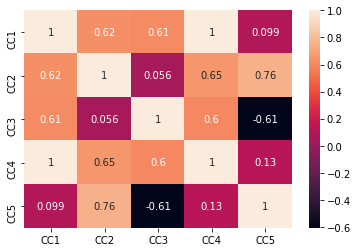

In [26]:
import seaborn as sns

import matplotlib.pyplot as plt

sns.heatmap(correlations, annot = True)

plt.show()

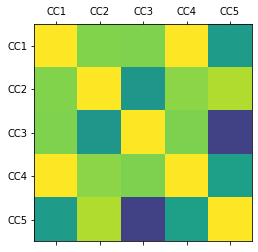

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
ticks = np.arange(0,5,1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(correlations.columns)
ax.set_yticklabels(correlations.columns)

plt.show()

# Model Construction

## Build Regression Models

__Our task is to predict the number of comments the post will receive ("Span count" column)__ <br>
"Span time" is necessary, while all other columns are optional <br>
Try a simple Multiple Regression model with only the basic features: <br>
["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"] <br>

Print out either the MSE score from sklearn or the RSS score learned from the course for both training and testing dataset

### Self Implementation

#### Visualize Correlation

##### Correlation between Span time and Span count

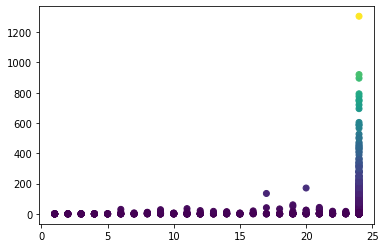

In [28]:
# Correlation between temperature and humidity
plt.scatter(train_data['Span time'], train_data['Span count'], c = train_data['Span count'])

##### Correlation Table

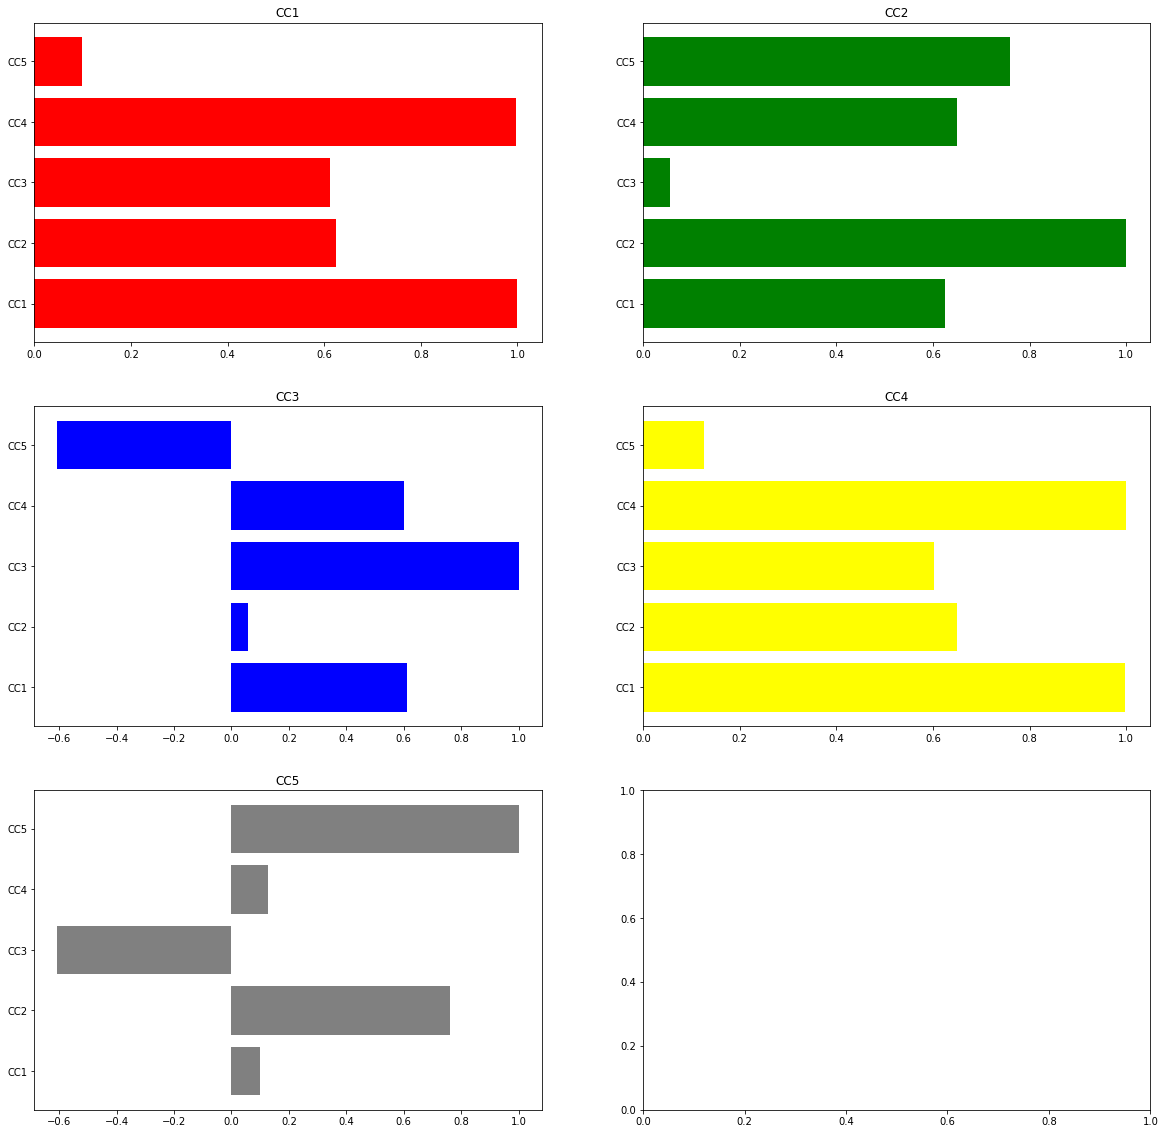

In [29]:
# Insert your code here:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

colors = ['red', 'green', 'blue', 'yellow', 'grey']
temp = 0

for i in range(4):
  for j in range(2):
    if (i + temp + j >= 5):
      break
    ax[i, j].barh(correlations.index, correlations[correlations.index[i + temp + j]], color=colors[i + temp +j])
    ax[i, j].title.set_text(correlations.columns[i + temp + j])
  temp += 1

plt.show()

#### Simple Linear Regression

##### Function Implementation

In [30]:
from scipy import stats

def correlation_approach(input, output):
  pearson_r = stats.pearsonr(input, output)[0]

  std_X = np.std(input)
  std_Y = np.std(output)

  mean_X = input.mean()
  mean_Y = output.mean()

  slope = pearson_r * (std_Y / std_X)
  intercept = mean_Y - slope * mean_X

  return intercept, slope

In [31]:
def sum_approach(input, output):
  N = len(input)

  sum_XY = np.dot(input, output)

  sum_X = sum(input)
  sum_Y = sum(output)

  sum_square_X = np.dot(input, input)

  mean_X = input.mean()
  mean_Y = output.mean()

  slope = (sum_XY - 1/N * sum_X * sum_Y) / (sum_square_X - 1/N * sum_X * sum_X)
  intercept = mean_Y - slope * mean_X

  return intercept, slope

In [32]:
def mean_approach(input, output):
  N = len(input)

  mean_XY = (input * output).mean()

  mean_X = input.mean()
  mean_Y = output.mean()

  mean_square_X = (input * input).mean()

  mean_X = input.mean()
  mean_Y = output.mean()

  slope = (mean_XY - mean_X * mean_Y) / (mean_square_X - mean_X * mean_X)
  intercept = mean_Y - slope * mean_X

  return intercept, slope

In [33]:
def predict(intercept, slope, feature):
  return intercept + slope * feature

##### Testing Section

###### Training Coefficient

In [34]:
from sklearn.linear_model import LinearRegression

feature = train_data["Span time"].values
label = train_data["Span count"].values

linear_model = LinearRegression().fit(np.reshape(feature, [-1, 1]), label)

print("- Built in Function:", (linear_model.intercept_, linear_model.coef_[0]))
print("- Correlation Approach:", correlation_approach(feature, label))
print("- Sum Approach:", sum_approach(feature, label))
print("- Mean Approach:", mean_approach(feature, label))

- Built in Function: (-2.287181759596926, 0.6314202540110866)
- Correlation Approach: (-2.2871817595970576, 0.6314202540110921)
- Sum Approach: (-2.2871817595972352, 0.6314202540110997)
- Mean Approach: (-2.2871817595969084, 0.6314202540110858)


In [35]:
# Built in function
prediction_1 = linear_model.predict(np.reshape(feature, [-1, 1]))

# Correlation Approach
intercept, slope = correlation_approach(feature, label)
prediction_2 = predict(intercept, slope, feature)

# Sum Approach
intercept, slope = sum_approach(feature, label)
prediction_3 = predict(intercept, slope, feature)

# Mean Approach
intercept, slope = mean_approach(feature, label)
prediction_4 = predict(intercept, slope, feature)

In [36]:
# Loss on Train Data
print("- Built in Function:", sklearn.metrics.mean_squared_error(label, prediction_1))
print("- Correlation Approach:", sklearn.metrics.mean_squared_error(label, prediction_2))
print("- Sum Approach:", sklearn.metrics.mean_squared_error(label, prediction_3))
print("- Mean Approach:", sklearn.metrics.mean_squared_error(label, prediction_4))

- Built in Function: 2287.3411679944597
- Correlation Approach: 2287.3411679944597
- Sum Approach: 2287.3411679944597
- Mean Approach: 2287.3411679944597


---

###### Prediction first value of test data

In [37]:
predict_value = test_data["Span time"].values[0]

prediction_1 = linear_model.predict(np.reshape(predict_value, [-1, 1]))
print("- Built in Function:", prediction_1[0])

intercept, slope = correlation_approach(feature, label)
prediction_2 = predict(intercept, slope, predict_value)
print("- Correlation Approach:", prediction_2)

intercept, slope = sum_approach(feature, label)
prediction_3 = predict(intercept, slope, predict_value)
print("- Sum Approach:", prediction_3)

intercept, slope = mean_approach(feature, label)
prediction_4 = predict(intercept, slope, predict_value)
print("- Mean Approach:", prediction_4)

- Built in Function: 11.604063828646979
- Correlation Approach: 11.60406382864697
- Sum Approach: 11.604063828646957
- Mean Approach: 11.604063828646979


##### Compute Loss

In [38]:
# Feature and Label for testing purpose
predict_value = test_data["Span time"].values
predict_label = test_data["Span count"].values

# Built in function
prediction_1 = linear_model.predict(np.reshape(predict_value, [-1, 1]))

# Correlation Approach
intercept, slope = correlation_approach(feature, label)
prediction_2 = predict(intercept, slope, predict_value)

# Sum Approach
intercept, slope = sum_approach(feature, label)
prediction_3 = predict(intercept, slope, predict_value)

# Mean Approach
intercept, slope = mean_approach(feature, label)
prediction_4 = predict(intercept, slope, predict_value)

In [39]:
# Loss on Test Data
print("- Built in Function:", sklearn.metrics.mean_squared_error(predict_label, prediction_1))
print("- Correlation Approach:", sklearn.metrics.mean_squared_error(predict_label, prediction_2))
print("- Sum Approach:", sklearn.metrics.mean_squared_error(predict_label, prediction_3))
print("- Mean Approach:", sklearn.metrics.mean_squared_error(predict_label, prediction_4))

- Built in Function: 18960.230763954936
- Correlation Approach: 18960.23076395494
- Sum Approach: 18960.23076395496
- Mean Approach: 18960.230763954933


##### Visualization

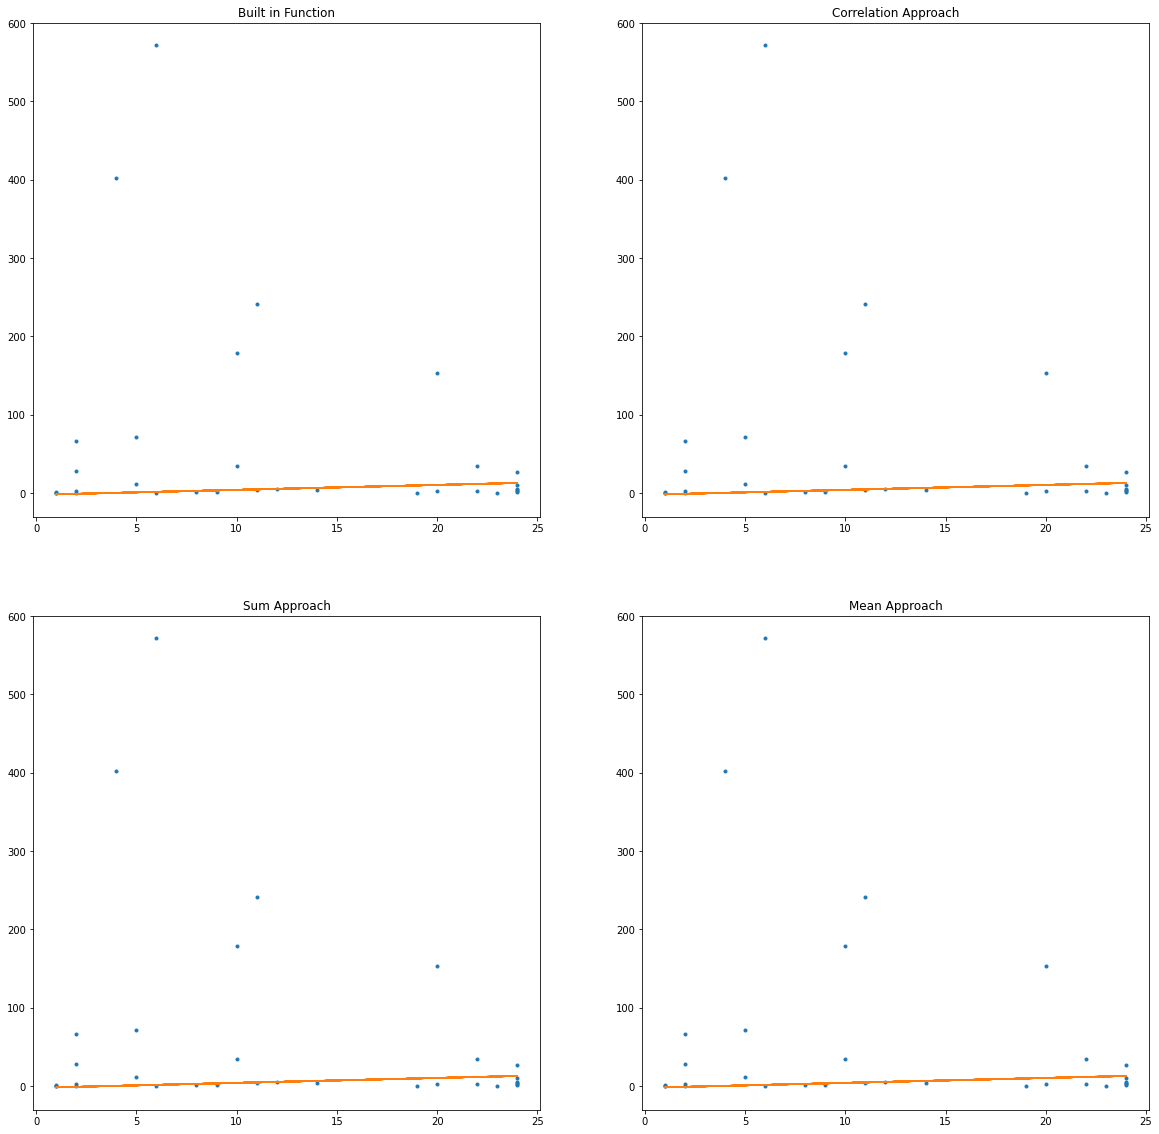

In [40]:
# Figure Define
fig, ax = plt.subplots(2, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

# Built in function
ax[0, 0].plot(predict_value, predict_label, ".",
         predict_value, prediction_1, "-")
ax[0, 0].title.set_text("Built in Function")

# Correlation Approach
ax[0, 1].plot(predict_value, predict_label, ".",
         predict_value, prediction_2, "-")
ax[0, 1].title.set_text("Correlation Approach")

# Sum Approach
ax[1, 0].plot(predict_value, predict_label, ".",
         predict_value, prediction_3, "-")
ax[1, 0].title.set_text("Sum Approach")

# Mean Approach
ax[1, 1].plot(predict_value, predict_label, ".",
         predict_value, prediction_4, "-")
ax[1, 1].title.set_text("Mean Approach")

# Show figure
plt.show()

#### Multiple Regression

##### Feature Extraction

In [41]:
def matrix_extraction(data, feature_list, label_list):
  data['constant'] = 1

  feature_list = ['constant'] + feature_list

  feature = data[feature_list].values
  label = data[label_list].values

  return feature, label

##### Matrix Equation Approach

###### Function Implementation

In [42]:
def fitted_weight(feature, label):
  return np.dot(np.dot(-feature.T, label), np.linalg.inv(np.dot(feature.T, feature)))

In [43]:
def predict(feature, weight):
  return feature.dot(weight)

##### Multiple Regression Testing Section

##### Regression Coefficient

In [44]:
feature_list = ["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]

feature = train_data[feature_list].values
label = train_data["Span count"].values

# Built in library
from sklearn.linear_model import SGDRegressor
sgd_model = SGDRegressor().fit(feature, label)
linear_model = LinearRegression().fit(feature, label)

print("- SGD Model:", (sgd_model.intercept_, sgd_model.coef_))
print("- Linear Model:", (linear_model.intercept_, linear_model.coef_))

- SGD Model: (array([6.72380994e+10]), array([-2.42504025e+14,  9.77761224e+12, -6.97793061e+13, -9.63585127e+13,
        1.33045759e+12,  6.57382213e+10]))
- Linear Model: (20.231090330358903, array([ 1.62928494e-06, -7.00240353e-01, -9.76139878e-04,  1.56269367e-02,
        3.44515956e-01,  0.00000000e+00]))


In [45]:
# (feature, label) = matrix_extraction(train_data, feature_list, "Span count")

# # Unrevertable
# weight = fitted_weight(feature, label)
# print("- Self Implement:", (weight))

##### Compute Loss

In [46]:
# Built in function
prediction_1 = sgd_model.predict(test_data[feature_list].values)
prediction_2 = linear_model.predict(test_data[feature_list].values)

print("- SGD Model:", sklearn.metrics.mean_squared_error(prediction_1, test_data["Span count"].values))
print("- Linear Model:", sklearn.metrics.mean_squared_error(prediction_2, test_data["Span count"].values))

- SGD Model: 2.076123798057721e+43
- Linear Model: 17959.79637960906


Moral of the day: Premature optimization are rarely ever worth it.

## Resolve overfit
### Applying resolution for overfit

The discrepancy between the score of the training and testing indicate that we may be overfitting the model. Let's try to fix it. Span the Ridge regression with alpha along logspace between 0 and 10, record the value with the best performance as variable `best_alpha`, and *optionally draw a graph for the coefficients magnitude*.

### Values Definition

In [47]:
feature_list = ["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]

# Training
feature = train_data[feature_list].values
label = train_data["Span count"].values

# Test
test_features = test_data[feature_list].values
test_labels = test_data["Span count"].values

### Discover Best Alpha


In [48]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

x_range = np.logspace(0, 10, num=21)

arr_alpha = {}
for l2_penalty in x_range:
  model = Ridge(alpha = l2_penalty).fit(feature, label)
  arr_alpha[str(l2_penalty)] = mean_squared_error(test_labels, model.predict(test_features))

arr_alpha

{'1.0': 17959.790059817853,
 '10.0': 17959.733194402565,
 '100.0': 17959.16579545186,
 '1000.0': 17953.61474596246,
 '10000.0': 17908.264586832083,
 '100000.0': 17781.98263039943,
 '1000000.0': 17968.4200212836,
 '10000000.0': 18776.05474434179,
 '100000000.0': 19170.17131068442,
 '1000000000.0': 19296.570241960733,
 '10000000000.0': 19629.83309508353,
 '3.1622776601683795': 17959.776395639972,
 '31.622776601683793': 17959.596666909303,
 '316.22776601683796': 17957.811868744546,
 '3162.2776601683795': 17941.13506022928,
 '31622.776601683792': 17844.720127886416,
 '316227.7660168379': 17797.060313416274,
 '3162277.6601683795': 18342.89733995796,
 '31622776.60168379': 19051.050773910363,
 '316227766.01683795': 19225.83677490954,
 '3162277660.1683793': 19440.64607262219}

In [49]:
best_alpha = min(arr_alpha, key=arr_alpha.get)
print('- Best Alpha:', best_alpha)

- Best Alpha: 100000.0


### Coefficient Path

In [50]:
# Initial
arr_coef = {}
for key in feature_list:
  arr_coef[str(key)] = []

# Generate Coefficient
for l2_penalty in x_range:
  model = Ridge(alpha = l2_penalty).fit(feature, label)
  for i in range(len(feature_list)):
    arr_coef[str(feature_list[i])].append(model.coef_[i])

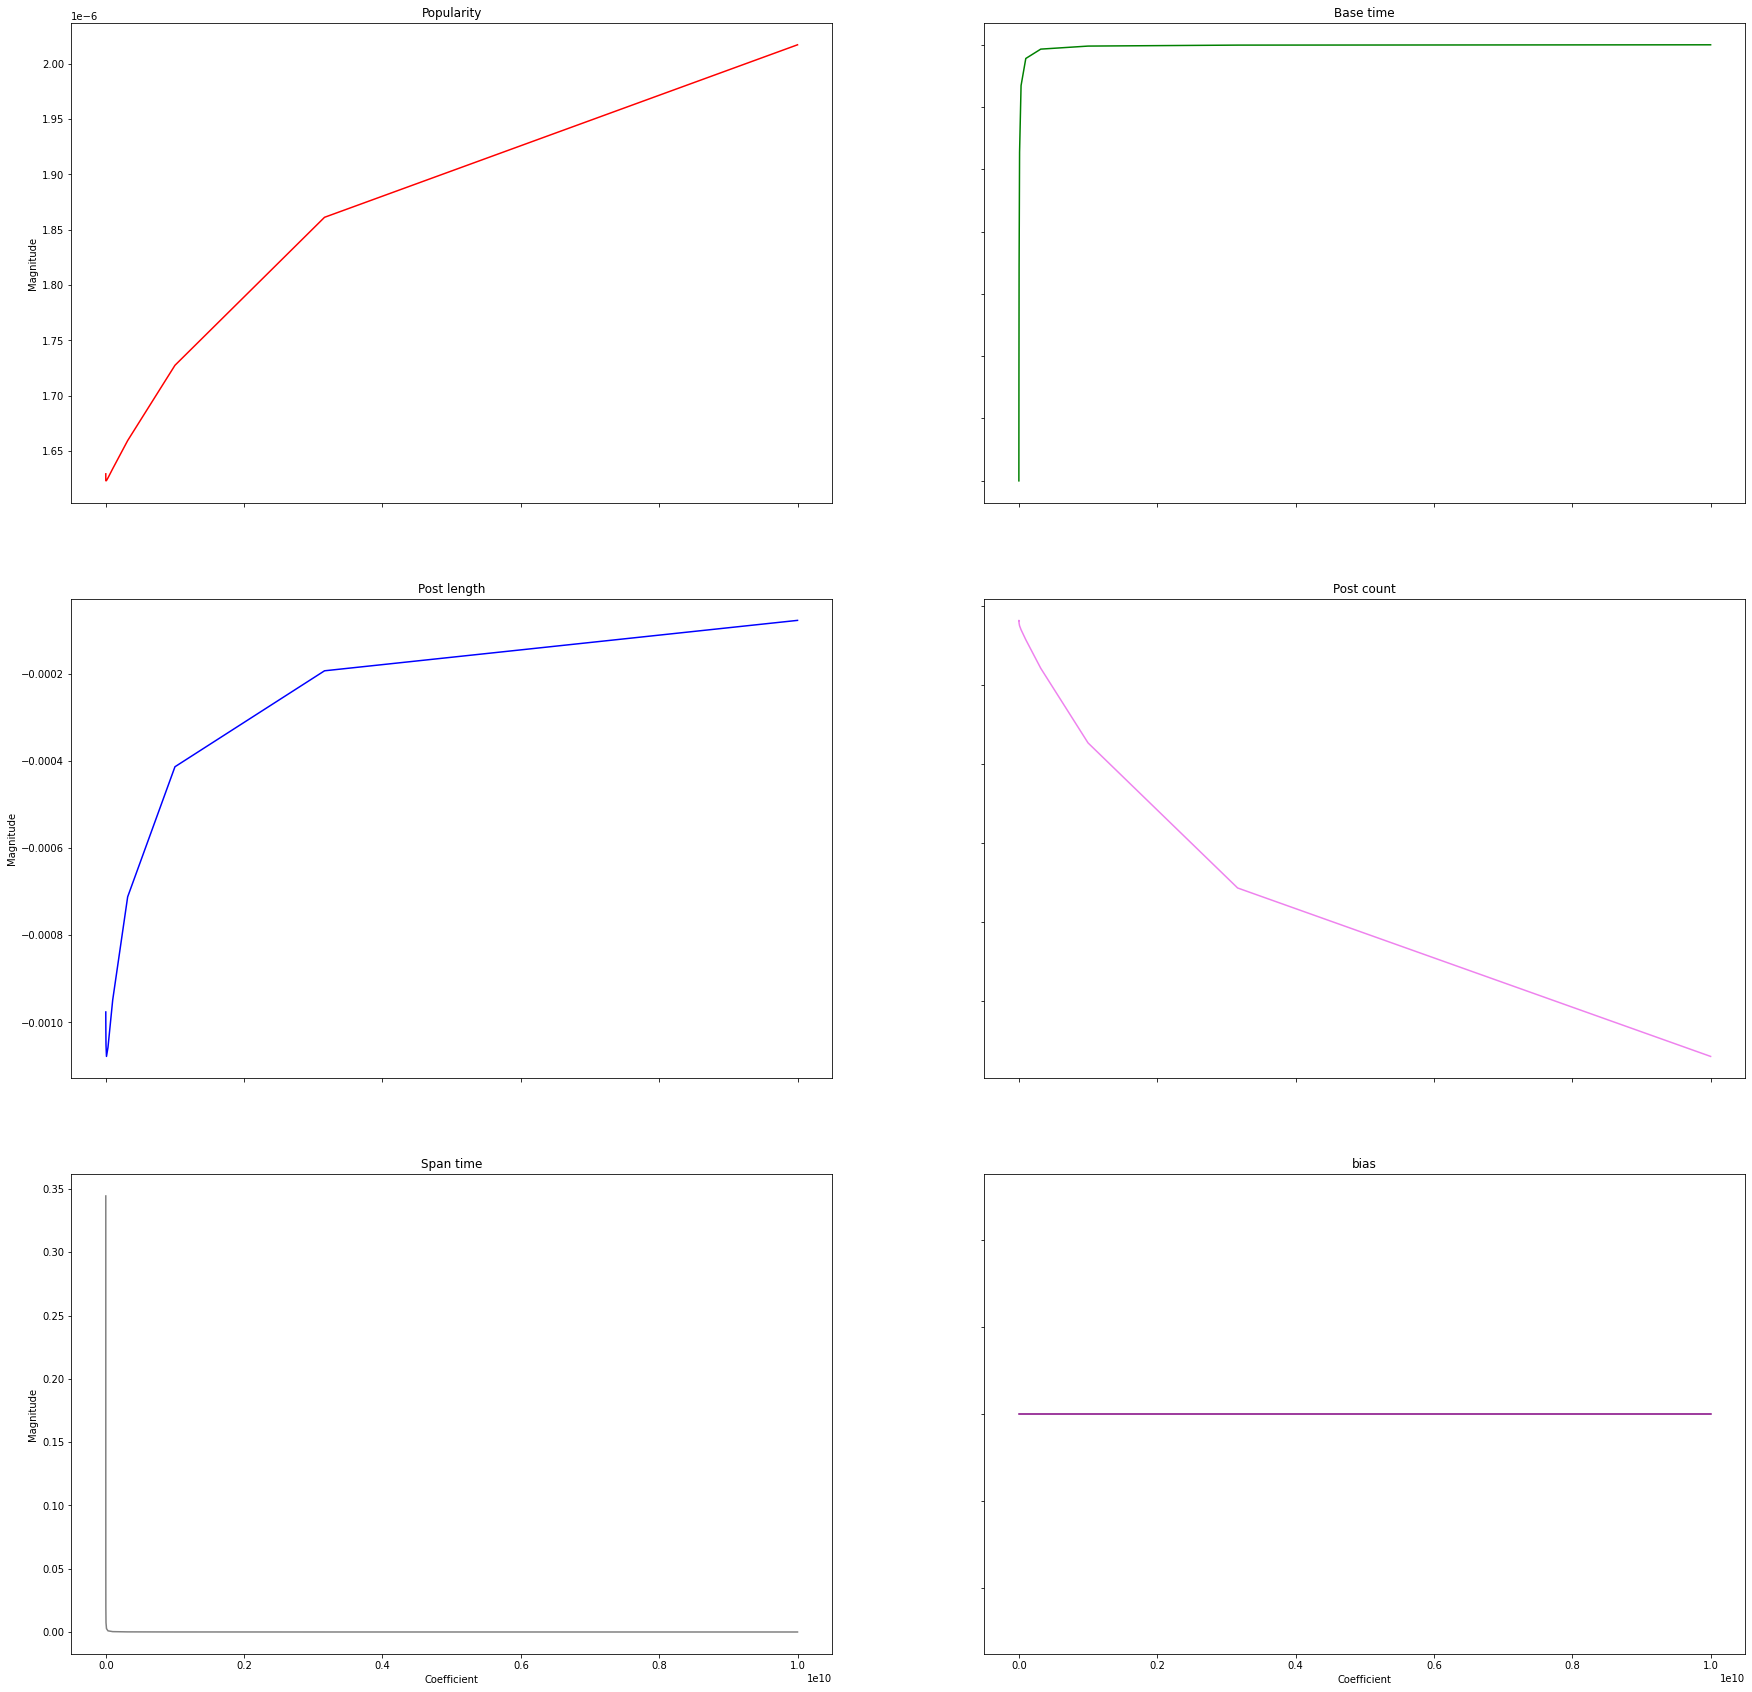

In [51]:
fig, axs = plt.subplots(3, 2)

fig.set_figheight(30)
fig.set_figwidth(30)

colors = ['red', 'green', 'blue', 'violet', 'grey', 'purple']

temp = 0

values = list(arr_coef.values())
keys = list(arr_coef.keys())

for i in range(3):
  for j in range(2):
    axs[i, j].plot(x_range, values[i + temp + j], color=colors[i + temp +j])
    axs[i, j].title.set_text(keys[i + temp + j])
  temp += 1

for ax in axs.flat:
    ax.set(xlabel='Coefficient', ylabel='Magnitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Evaluate on Test Set

In [52]:
evaluate_model = Ridge(alpha = best_alpha).fit(feature, label)

In [53]:
print("- RSS on Train Set:", mean_squared_error(label, evaluate_model.predict(feature)))
print("- RSS on Test Set:", mean_squared_error(test_labels, evaluate_model.predict(test_features)))

- RSS on Train Set: 1909.0719156350428
- RSS on Test Set: 17781.98263039943


### Try Ridge Regression on every columns
It worked, but one have to wonder if we are still using the incomplete set of features instead of the optimal one. Expand the features to all columns except our designated label. Run and see what happens.

In [54]:
# Import scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Train feature and label
train_features = train_data[features]
train_labels = train_data["Span count"]

# Test feature and label
test_features = test_data[features]
test_labels = test_data["Span count"]

# Rescale feature
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Model construction
multi_model = LinearRegression()
multi_model.fit(train_features, train_labels)

# Generate prediction
test_predictions = multi_model.predict(test_features)

# Compute Loss
test_mse_score = mean_squared_error(test_labels, test_predictions)
train_mse_score = mean_squared_error(train_labels, multi_model.predict(train_features))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))

MSE on training: 1920.0113; MSE on test: 10178.5489


## Features selection
### Apply LASSO
Now, we can try trimming the features using something we had learned throughout the course. This time record the selected features of LASSO using variable `lasso_selected_features`, and <i>optionally draw a graph between number of removed features and alpha values</i>.

### Select L1 Penalty

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

def k_fold_cross_validation(k, l1_penalty, data, output_name, features_list):
    n = len(data)
    mean_error = 0
    for i in range(k):
      start = (n * i) // k
      end = (n * (i+1)) // k-1

      validation = data[start:end+1]
      training = data[0:start].append(data[end+1:n])

      model = Lasso(alpha=l1_penalty).fit(training[features_list].values, training[output_name].values)

      mean_error += mean_squared_error(validation[output_name].values, model.predict(validation[features_list].values))
    return (mean_error / k), np.count_nonzero(model.coef_)

In [56]:
arr_errors = []
arr_discarded = []

k = 10

for l1_penalty in np.logspace(0, 10, num=21):
  err, discard = k_fold_cross_validation(k, l1_penalty, train_data, "Span count", features)

  arr_errors.append(err)
  arr_discarded.append(discard)

arr_errors

[1828.0927474521243,
 1816.8898023985075,
 1812.9203968789916,
 1809.0970520326314,
 1835.5566683584977,
 1929.1502232031482,
 2014.63100547319,
 2193.790906923906,
 2312.705793431295,
 2308.043092214442,
 2296.488442497234,
 2289.973801620855,
 2288.2542779772934,
 2284.325951391097,
 2286.996338165404,
 2292.9570188196763,
 2292.9570188196763,
 2292.9570188196763,
 2292.9570188196763,
 2292.9570188196763,
 2292.9570188196763]

### Visualization

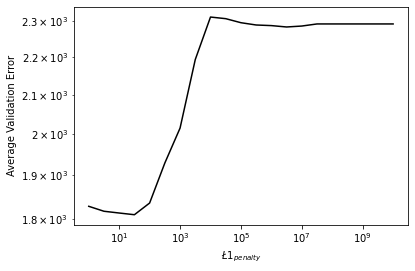

In [57]:
plt.plot(np.logspace(0, 10, num=21), arr_errors, 'k-')
plt.xlabel('$\L1_{penalty}$')
plt.ylabel('Average Validation Error')
plt.xscale('log')
plt.yscale('log')

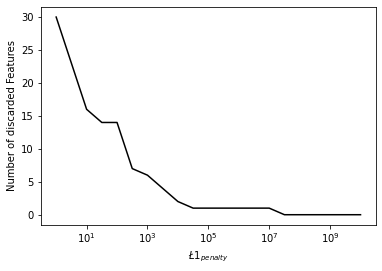

In [58]:
total = len(features)
plt.plot(np.logspace(0, 10, num=21), arr_discarded, 'k-')
plt.xlabel('$\L1_{penalty}$')
plt.ylabel('Number of discarded Features')
plt.xscale('log')

### Best L1 Penalty

In [59]:
best_l1_penalty = np.logspace(0, 10, num=21)[arr_errors.index(min(arr_errors))]
best_l1_penalty

31.622776601683793

### Feature Selection

In [60]:
lasso_feature = train_data[features].values
lasso_label = train_data["Span count"].values
Lasso_model = Lasso(alpha=best_l1_penalty).fit(lasso_feature, lasso_label)
Lasso_model.coef_

array([ 1.34775634e-06, -3.20111554e-05, -1.81163159e-05, -0.00000000e+00,
        1.77890377e-03,  3.06959654e-02,  0.00000000e+00,  3.71905592e-02,
       -0.00000000e+00, -3.56393154e-03,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -8.28117026e-03,  6.19945132e-02,  0.00000000e+00, -0.00000000e+00,
        4.23885200e-02, -4.30876705e-01, -1.37919350e-03,  1.14565666e-02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00])

In [61]:
lasso_selected_features = [features[idx] for idx, val in enumerate(model.coef_) if val != 0]
lasso_selected_features

['Popularity', 'Check-in', 'Activities', 'F_1', 'F_2']

### Build a model strictly with the selected features
Remember that when you do features selecting, you may have to re-add bias into the list of features yet again. Use the selected features to build a model and calculate the performance basing on the metrics.

In [62]:
if("bias" not in lasso_selected_features):
    lasso_selected_features.append('bias')

## Combine everything on one model
So LASSO performed admirably, shrinking aways unnecessary and noisy features and quicken the speed of calculation. Now let us combine both previous techniques together on one model.

In [63]:
# Train feature and label
train_features = train_data[lasso_selected_features]
train_labels = train_data["Span count"]

# Test feature and label
test_features = test_data[lasso_selected_features]
test_labels = test_data["Span count"]

# Rescale feature
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Model construction
strict_model = LinearRegression()
strict_model.fit(train_features, train_labels)

# Generate prediction
test_predictions = strict_model.predict(test_features)

# Compute Loss
test_mse_score = mean_squared_error(test_labels, test_predictions)
train_mse_score = mean_squared_error(train_labels, strict_model.predict(train_features))
print("MSE on training: {:.4f} \nMSE on test: {:.4f}".format(train_mse_score, test_mse_score))

MSE on training: 2229.8162 
MSE on test: 18175.9425


### Distribution of square errors
The conclusion is yours to draw. As a side note, let's see how the square errors are distributed.

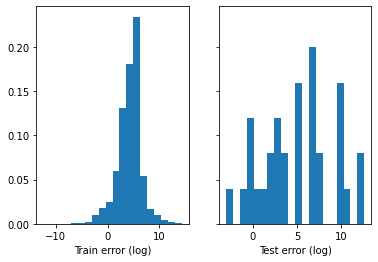

In [64]:
train_square_errors = np.log( (train_labels - strict_model.predict(train_features)) ** 2)
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )

fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)

train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")

test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)

plt.show()

In [65]:
train_square_errors = np.log( (train_labels - multi_model.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()

ValueError: ignored

### Try improving with more features
Not the greatest model we could use. We should try to add even more relevant features. <br>Append all the CC properties to the features and try again, with the same metrics.

In [68]:
extend_feature = lasso_selected_features + ['CC1', 'CC2', 'CC3', 'CC4', 'CC5']

# Train feature and label
train_features = train_data[extend_feature]
train_labels = train_data["Span count"]

# Test feature and label
test_features = test_data[extend_feature]
test_labels = test_data["Span count"]

# Rescale feature
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Model construction
final_model = LinearRegression()
final_model.fit(train_features, train_labels)

# Generate prediction
test_predictions = final_model.predict(test_features)

# Compute Loss
test_mse_score = mean_squared_error(test_labels, test_predictions)
train_mse_score = mean_squared_error(train_labels, final_model.predict(train_features))
print("MSE on training: {:.4f} \nMSE on test: {:.4f}".format(train_mse_score, test_mse_score))

MSE on training: 1922.7378 
MSE on test: 7742.3271


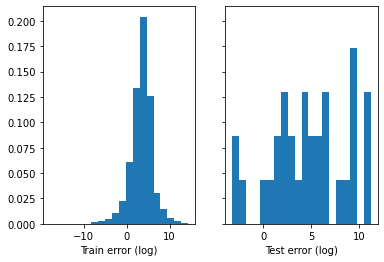

In [69]:
train_square_errors = np.log( (train_labels - final_model.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()